In [ ]:
#Bibliotecas
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import anderson
import statsmodels.api as sm

Foram importadas algumas bliotecas, da linguagem de programação python, com o objetivo de facilitar a analise e manipulamento de dados.

o objetivo das importações de códigos externos foram:
pandas: Manipulação de dados em estruturas como DataFrames, ideal para carregar, limpar e transformar dados.
pyarrow.parquet: Leitura e escrita de arquivos no formato Parquet, eficiente para grandes volumes de dados.
seaborn: Criação de gráficos estatísticos atraentes e informativos, com integração facilitada ao pandas.
matplotlib.pyplot: Biblioteca básica para visualização de dados com gráficos personalizados.
numpy: Operações matemáticas e manipulação eficiente de arrays.
scipy.stats: Funções estatísticas e testes de hipóteses.
statsmodels: Modelagem estatística, regressões e testes avançados.
anderson: Teste estatístico de Anderson-Darling, útil para verificar a normalidade dos dados.

In [ ]:
#Carregando a base
df = pd.read_excel('BASE_limpa_2.xlsx')

df.head(5)

,ano_campeonato,data,rodada,estadio,arbitro,publico,time_mandante,time_visitante,tecnico_mandante,tecnico_visitante,colocacao_mandante,colocacao_visitante,valor_equipe_titular_mandante,valor_equipe_titular_visitante,idade_media_titular_mandante,idade_media_titular_visitante,gols_mandante,gols_visitante,gols_1_tempo_mandante,gols_1_tempo_visitante
0,2003,2003-05-11,8,Arena do Grêmio,NaN,NaN,Grêmio,Coritiba FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN
1,2003,2003-06-15,13,Arena do Grêmio,NaN,NaN,Grêmio,Internacional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,2003,2003-07-06,16,Arena do Grêmio,NaN,NaN,Grêmio,Flamengo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN
3,2003,2003-08-02,23,Arena do Grêmio,NaN,NaN,Grêmio,Santos FC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN
4,2003,2003-08-23,28,Arena do Grêmio,NaN,NaN,Grêmio,São Caetano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


Na analise inicial da base, foi entendido que não seria necessária nenhuma remoção de colunas nos dados encontrados na base, contudo após primeiros desenvolvimentos, constatou-se que a falta de informações em cerca de 15 anos dos 21 que se encontram na analise, implicaria em dados faltantes caso fossem usadas as médias dos campos e em poucos dados para analisar nos anos restantes. Foram removidos as colunas de escanteios mandante e visitante
faltas mandante e visitante,
chute bolas parada mandante e visitante,
defesas mandante e visitante,
impedimentos mandante e visitante,
chutes mandante e visitante, por fim
chutes fora mandante e visitante.


In [ ]:
#informações sobre a base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ano_campeonato                  8357 non-null   int64         
 1   data                            8357 non-null   datetime64[ns]
 2   rodada                          8357 non-null   int64         
 3   estadio                         8346 non-null   object        
 4   arbitro                         6647 non-null   object        
 5   publico                         6646 non-null   float64       
 6   time_mandante                   8357 non-null   object        
 7   time_visitante                  8357 non-null   object        
 8   tecnico_mandante                6203 non-null   object        
 9   tecnico_visitante               6203 non-null   object        
 10  colocacao_mandante              6645 non-null   float64       
 11  colo

Ficando após essa primeira tratativa, 1 campo de tipo data, 13 campos de tipo númerico (11 com números reais e 2 com números inteiros) e 6 com informações categoricas (informação em texto).

Alguns campos mesmo estando com tipagem float, contiam dados que são identificados como inteiros, para adequar os dados, foi alterado o tipo dos campos para seguir o tipo inteiro.

Foram separados os campos de tipo texto na variavel de colunas_categoricas e númericas em colunas_numericas.

In [ ]:
# Alterar colunas de float para int
cols = ['publico', 'gols_mandante', 'gols_visitante', 'gols_1_tempo_mandante', 'gols_1_tempo_visitante',
        'colocacao_mandante', 'colocacao_visitante', 'ano_campeonato']

df[cols] = df[cols].astype(pd.Int64Dtype())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ano_campeonato                  8357 non-null   Int64         
 1   data                            8357 non-null   datetime64[ns]
 2   rodada                          8357 non-null   int64         
 3   estadio                         8346 non-null   object        
 4   arbitro                         6647 non-null   object        
 5   publico                         6646 non-null   Int64         
 6   time_mandante                   8357 non-null   object        
 7   time_visitante                  8357 non-null   object        
 8   tecnico_mandante                6203 non-null   object        
 9   tecnico_visitante               6203 non-null   object        
 10  colocacao_mandante              6645 non-null   Int64         
 11  colo

In [ ]:
def replace_values(df, mapping_dict):
    """
    Substitui valores nas colunas 'time_visitante' e 'time_mandante' de um DataFrame
    a partir de um dicionário de mapeamento.

    Args:
    df (pd.DataFrame): DataFrame contendo as colunas a serem modificadas.
    mapping_dict (dict): Dicionário com os valores a serem substituídos como chaves e os novos valores como valores.

    Returns:
    pd.DataFrame: DataFrame com os valores substituídos.
    """
    columns_to_replace = ['time_visitante', 'time_mandante']
    for column in columns_to_replace:
        df[column] = df[column].replace(mapping_dict)
    return df

In [ ]:
mapping_dict = {"Atlético-PR": "Athletico-PR", "FC": "",
                 "EC": "", "Coritiba FC": "Coritiba", "Goias EC": "Goiás","Goiás EC": "Goiás", "Santos FC": "Santos","Avaí FC": "Avaí",
"Ceará FC": "Ceará", "Criciúma EC": "Criciúma", "EC Vitória": "Vitória","Ipatinga FC": "Ipatinga","Joinville-SC": "Joinville", "Ceará SC": "Ceará",}


df = replace_values(df, mapping_dict)

In [ ]:
#informações sobre a base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ano_campeonato                  8357 non-null   Int64         
 1   data                            8357 non-null   datetime64[ns]
 2   rodada                          8357 non-null   int64         
 3   estadio                         8346 non-null   object        
 4   arbitro                         6647 non-null   object        
 5   publico                         6646 non-null   Int64         
 6   time_mandante                   8357 non-null   object        
 7   time_visitante                  8357 non-null   object        
 8   tecnico_mandante                6203 non-null   object        
 9   tecnico_visitante               6203 non-null   object        
 10  colocacao_mandante              6645 non-null   Int64         
 11  colo

In [ ]:
#função para retirar todos os valores Nan, Null e Infinitos do df
def remove_nan_inf(df):
    """
    Remove valores NaN, Null e infinitos de um DataFrame.

    Args:
    df (pd.DataFrame): DataFrame a ser limpo.

    Returns:
    pd.DataFrame: DataFrame sem valores NaN, Null e infinitos.
    """
    return df.replace([np.inf, -np.inf], np.nan).dropna()

df = remove_nan_inf(df)

In [ ]:
# Separar em Colunas numéricas
colunas_numericas = df.select_dtypes(include=['int', 'float']).columns
colunas_numericas

Index(['ano_campeonato', 'rodada', 'publico', 'colocacao_mandante',
       'colocacao_visitante', 'valor_equipe_titular_mandante',
       'valor_equipe_titular_visitante', 'idade_media_titular_mandante',
       'idade_media_titular_visitante', 'gols_mandante', 'gols_visitante',
       'gols_1_tempo_mandante', 'gols_1_tempo_visitante'],
      dtype='object')

In [ ]:
#Separar em Colunas categóricas
colunas_categoricas = df.select_dtypes(include=['object']).columns
colunas_categoricas

Index(['estadio', 'arbitro', 'time_mandante', 'time_visitante',
       'tecnico_mandante', 'tecnico_visitante'],
      dtype='object')

In [ ]:
#Estatísticas descritivas
df.describe().T.round()


,count,mean,min,25%,50%,75%,max,std
ano_campeonato,5801.0,2014.912257,2007.0,2011.0,2015.0,2019.0,2023.0,4.714547
data,5801,2015-07-28 15:15:14.118255360,2007-05-03 00:00:00,2011-08-17 00:00:00,2015-07-30 00:00:00,2019-09-14 00:00:00,2023-12-07 00:00:00,NaN
rodada,5801.0,19.587485,1.0,10.0,20.0,29.0,38.0,10.987201
publico,5801.0,15460.228237,0.0,5520.0,12285.0,21814.0,82044.0,13687.551178
colocacao_mandante,5801.0,10.538873,1.0,6.0,10.0,16.0,20.0,5.73383
colocacao_visitante,5801.0,10.273401,1.0,5.0,10.0,15.0,20.0,5.739013
valor_equipe_titular_mandante,5801.0,17493250.694018,560.0,7050000.0,13050000.0,24900000.0,100500000.0,14495171.5772
valor_equipe_titular_visitante,5801.0,17099661.801414,593.0,7100000.0,12900000.0,24150000.0,96000000.0,13921663.649342
idade_media_titular_mandante,5801.0,27.325634,20.4,26.2,27.3,28.4,33.6,1.618572
idade_media_titular_visitante,5801.0,27.202207,20.5,26.1,27.2,28.3,33.1,1.649576


Ficando então com os seguintes campos, possuindo na tabela seus quartis, quantidade máxima, média, máximo, minimo e desvio padrão:


Ano do Campeonato
Os dados relacionados ao campo "ano_campeonato" mostram que a média dos campeonatos considerados está em 2013, com o menor ano sendo 2003 e o maior 2024. O desvio padrão de 6.29 indica uma variação moderada nos anos analisados, o que sugere que as competições cobrem um longo período de tempo. O primeiro quartil (25%) está em 2007 e o terceiro quartil (75%) em 2018, reforçando que a maioria dos dados está concentrada entre esses anos.

Rodada
O campo "rodada" possui uma média de aproximadamente 19, indicando que, em média, os jogos acontecem ao redor da metade do campeonato (dado que muitos campeonatos têm cerca de 38 rodadas). O valor mínimo é 1, enquanto o máximo é 38, cobrindo uma temporada completa. O desvio padrão de 10.95 mostra uma variação considerável nas rodadas dos jogos registrados.

Público
No que se refere ao "público", observa-se que a média de espectadores por jogo é de 15.949, com valores variando de 0 (jogos sem público, possivelmente devido a restrições) até um máximo de 82.044 pessoas. O desvio padrão de 13.943 sugere que há uma grande variação na quantidade de público, possivelmente em função do tamanho dos estádios ou da importância das partidas. O valor do 1º quartil (5787) indica que, em 25% das partidas, o público foi inferior a esse número, enquanto o 3º quartil (22.584) mostra que 75% das partidas tiveram menos de 22.584 espectadores.

Colocação das Equipes
A colocação das equipes (mandante e visitante) apresenta uma média em torno de 10 para ambos os times, sugerindo que, em geral, as equipes participantes estão distribuídas de forma relativamente homogênea na tabela do campeonato. O desvio padrão de cerca de 5.7 indica uma variação considerável na posição das equipes, com algumas partidas envolvendo times na liderança e outras com times de posições mais baixas.

Valor das Equipes
Em relação ao "valor_equipe_titular", tanto de mandantes quanto de visitantes, a média está em torno de 16 milhões. O desvio padrão elevado (aproximadamente 14 milhões) sugere que há uma grande disparidade entre os valores das equipes, refletindo a diferença de investimento e orçamento entre os clubes. O valor máximo de 100 milhões de reais para o time mandante e 96 milhões para o visitante reforça essa discrepância, enquanto os valores do 1º quartil indicam que 25% dos times possuem elencos avaliados em menos de 6 milhões.

Idade Média dos Jogadores Titulares
Quanto à idade média dos jogadores titulares, os times mandantes têm uma média de 27,29 anos e os visitantes 27,19 anos. O desvio padrão é baixo, com cerca de 1,6 para ambos, indicando que a maioria dos jogadores tem idades muito próximas dessa média. O valor máximo é de 33,6 anos para mandantes e 33,1 anos para visitantes, enquanto o mínimo fica em torno de 20 anos para ambos os lados, o que demonstra a presença tanto de jovens promessas quanto de jogadores mais experientes.

Gols
Os dados de "gols_mandante" e "gols_visitante" mostram uma média de 1,52 gols por partida para os mandantes e 1,02 para os visitantes, indicando que os times da casa tendem a marcar mais gols. A variação, refletida no desvio padrão (1,21 para mandantes e 1,02 para visitantes), também mostra que algumas partidas podem ter mais gols que a média. No entanto, o primeiro quartil para ambos os casos é 1 e 0 gols, sugerindo que uma quantidade significativa de jogos termina com poucos ou nenhum gol marcado.

Essas informações permitem uma análise detalhada sobre os jogos, revelando padrões e variações nas rodadas, no público, no desempenho das equipes e no valor dos elencos.

##Graficos

In [ ]:
# Correlações
corr = df.corr(numeric_only=True)
corr.style.background_gradient()

,ano_campeonato,rodada,publico,colocacao_mandante,colocacao_visitante,valor_equipe_titular_mandante,valor_equipe_titular_visitante,idade_media_titular_mandante,idade_media_titular_visitante,gols_mandante,gols_visitante,gols_1_tempo_mandante,gols_1_tempo_visitante
ano_campeonato,1.000000,-0.007982,0.041392,-0.011581,0.015989,0.236432,0.224931,0.351382,0.315287,-0.093618,-0.069043,-0.062570,-0.059226
rodada,-0.007982,1.000000,0.115112,-0.008926,0.001248,0.024056,0.019537,0.005364,0.006478,0.017863,-0.000134,0.006006,0.003268
publico,0.041392,0.115112,1.000000,-0.293689,-0.070792,0.264833,0.072577,0.050890,0.019633,0.029920,-0.076008,0.012919,-0.052751
colocacao_mandante,-0.011581,-0.008926,-0.293689,1.000000,-0.049098,-0.423592,0.019771,-0.010824,0.009247,-0.146535,0.083849,-0.094289,0.058931
colocacao_visitante,0.015989,0.001248,-0.070792,-0.049098,1.000000,0.007505,-0.429460,0.007232,0.023399,0.130726,-0.100834,0.076558,-0.054798
valor_equipe_titular_mandante,0.236432,0.024056,0.264833,-0.423592,0.007505,1.000000,0.148943,0.107466,0.075822,0.118970,-0.041269,0.100184,-0.043060
valor_equipe_titular_visitante,0.224931,0.019537,0.072577,0.019771,-0.429460,0.148943,1.000000,0.084575,0.058085,-0.149707,0.145395,-0.086364,0.091898
idade_media_titular_mandante,0.351382,0.005364,0.050890,-0.010824,0.007232,0.107466,0.084575,1.000000,0.121931,-0.035139,-0.053842,-0.011321,-0.045147
idade_media_titular_visitante,0.315287,0.006478,0.019633,0.009247,0.023399,0.075822,0.058085,0.121931,1.000000,-0.035801,-0.031593,-0.041225,-0.011772
gols_mandante,-0.093618,0.017863,0.029920,-0.146535,0.130726,0.118970,-0.149707,-0.035139,-0.035801,1.000000,0.040940,0.665831,0.035693


A tabela de correlação apresentada oferece insights sobre as relações entre variáveis relacionadas a campeonatos de futebol. A correlação vai de -1 (fortemente negativa) a +1 (fortemente positiva), com valores mais próximos de zero indicando pouca ou nenhuma relação entre as variáveis.

1. Ano do Campeonato
Correlação positiva moderada com idade média dos titulares (mandante: 0.35; visitante: 0.32): Isso sugere que, com o passar dos anos, a idade média dos jogadores aumentou. Pode ser resultado de mudanças no perfil dos atletas, com jogadores mais experientes se mantendo em atividade por mais tempo.
Correlação negativa com gols (mandante: -0.11; visitante: -0.05): Indica que, com o tempo, os times tendem a marcar menos gols, especialmente os mandantes. Isso pode refletir mudanças táticas, como defesas mais organizadas ou competições mais equilibradas.
2. Rodada
Correlação baixa com todas as variáveis: Isso sugere que a rodada do campeonato não influencia significativamente outras variáveis, como público, gols ou desempenho das equipes. Isso pode indicar que o comportamento das partidas se mantém relativamente constante ao longo da competição.
3. Público
Correlação positiva com o valor da equipe titular do mandante (0.19): Equipes com maior valor de mercado tendem a atrair mais público. Isso faz sentido, já que times mais valiosos frequentemente têm jogadores mais renomados e campanhas mais vitoriosas.
Correlação negativa com colocação do mandante (-0.29): Times que estão em posições piores na tabela tendem a ter públicos menores. Quando uma equipe vai mal no campeonato, a torcida tende a comparecer menos.
4. Colocação do Mandante e Visitante
Correlação negativa com valor da equipe titular do mandante (-0.39) e do visitante (-0.40): Times que estão em melhores posições na tabela tendem a ter elencos mais valiosos. Isso reflete a influência de investimentos financeiros no desempenho.
Correlação positiva com gols do visitante (0.14) e negativa com gols do mandante (-0.15): Times mandantes que estão melhor colocados tendem a sofrer menos gols, enquanto os visitantes, quando estão em boas posições, marcam mais gols. Isso reflete o equilíbrio e a competitividade nas partidas.
5. Valor da Equipe Titular (Mandante e Visitante)
Correlação positiva com público (mandante: 0.19): Como mencionado, equipes mais valiosas atraem mais torcedores.
Correlação positiva com gols do mandante (0.12): Equipes mandantes mais valiosas tendem a marcar mais gols, reforçando o impacto do valor do elenco no desempenho em campo.
6. Idade Média dos Titulares (Mandante e Visitante)
Correlação positiva com ano do campeonato (mandante: 0.35; visitante: 0.32): Como já discutido, isso indica uma tendência de envelhecimento dos jogadores ao longo dos anos.
Correlação baixa com outras variáveis: A idade média dos jogadores não parece ter uma relação forte com o número de gols ou a colocação das equipes, sugerindo que a experiência (medida pela idade) não tem impacto direto no desempenho em campo, pelo menos nessa análise.
7. Gols (Mandante e Visitante)
Correlação muito alta entre gols do 1º tempo e gols totais (mandante: 0.66; visitante: 0.64): Não é surpreendente, já que os gols marcados no 1º tempo contribuem diretamente para o total de gols na partida. Isso mostra que muitas das partidas têm sua tendência de placar definida desde o primeiro tempo.
Correlação negativa entre valor da equipe visitante e gols do mandante (-0.13): Times visitantes mais valiosos tendem a permitir menos gols, sugerindo que elencos mais fortes podem ser mais defensivamente eficientes.
Conclusões Gerais
A tabela revela que o valor da equipe titular está fortemente relacionado com o desempenho (gols e posição na tabela), evidenciando o papel do investimento financeiro no sucesso de uma equipe.
A idade média dos jogadores aumentou ao longo dos anos, mas esse fator tem pouco impacto sobre o número de gols ou a posição das equipes.
O público está correlacionado positivamente com o valor das equipes e negativamente com a posição na tabela, o que reforça que torcedores apoiam mais os times quando estão bem e quando têm elencos de maior valor.

In [ ]:
 # Filtrar os dados da coluna, removendo valores NaN
data = df[colunas_numericas].dropna()
df.head()

,ano_campeonato,data,rodada,estadio,arbitro,publico,time_mandante,time_visitante,tecnico_mandante,tecnico_visitante,colocacao_mandante,colocacao_visitante,valor_equipe_titular_mandante,valor_equipe_titular_visitante,idade_media_titular_mandante,idade_media_titular_visitante,gols_mandante,gols_visitante,gols_1_tempo_mandante,gols_1_tempo_visitante
1722,2007,2007-05-20,2,Allianz Parque,Lourival Dias Lima Filho,19047,Palmeiras,Figueirense FC,Caio Júnior,Mário Sérgio,4,18,3750000.0,50000.0,26.5,23.0,2,1,2,0
1723,2007,2007-06-03,4,Allianz Parque,Wagner Tardelli Azevedo,13381,Palmeiras,Cruzeiro,Caio Júnior,Dorival Júnior,4,18,3000000.0,100000.0,24.9,27.2,1,3,1,2
1724,2007,2007-06-10,5,Allianz Parque,Evandro Rogerio Roman,21322,Palmeiras,Botafogo,Caio Júnior,Cuca,7,1,3750000.0,300000.0,26.9,24.5,1,1,1,0
1725,2007,2007-06-24,7,Allianz Parque,Álvaro Azeredo Quelhas,17552,Palmeiras,Athletico-PR,Caio Júnior,Antônio Lopes,11,10,2500000.0,1650000.0,26.5,25.1,0,2,0,1
1726,2007,2007-07-20,12,Allianz Parque,Salvio Fagundes Filho,18662,Palmeiras,Santos,Caio Júnior,Vanderlei Luxemburgo,4,14,5750000.0,7500000.0,26.4,26.4,2,2,1,2


In [ ]:
# Remover NaN
df.dropna(axis = 0, inplace = True)
df.isna().sum()

,0
ano_campeonato,0
data,0
rodada,0
estadio,0
arbitro,0
publico,0
time_mandante,0
time_visitante,0
tecnico_mandante,0
tecnico_visitante,0


###Histogramas


(array([1253., 2014.,    0., 1454.,    0.,  720.,  264.,    0.,   79.,
          17.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

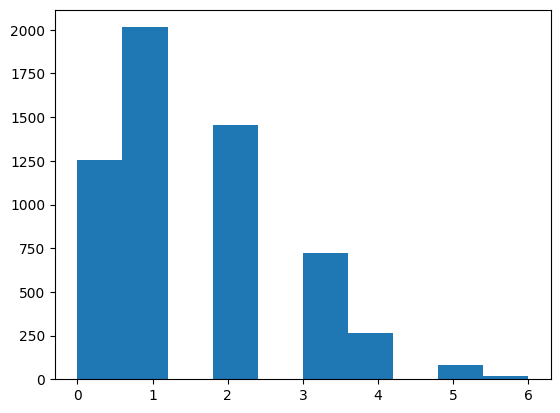

In [ ]:
plt.hist(df['gols_mandante'])

(array([2.261e+03, 2.078e+03, 1.049e+03, 0.000e+00, 3.150e+02, 8.300e+01,
        0.000e+00, 1.300e+01, 1.000e+00, 1.000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

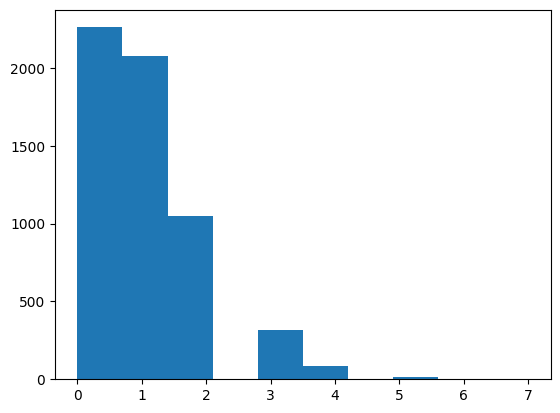

In [ ]:
plt.hist(df['gols_visitante'])

(array([2.954e+03, 0.000e+00, 2.035e+03, 0.000e+00, 6.490e+02, 0.000e+00,
        1.350e+02, 0.000e+00, 2.700e+01, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

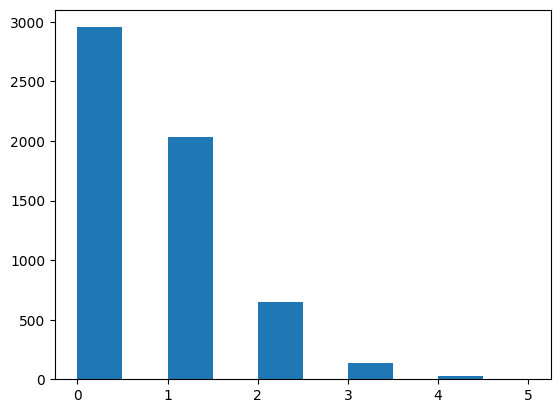

In [ ]:
plt.hist(df['gols_1_tempo_mandante'])

(array([3.812e+03, 0.000e+00, 1.614e+03, 0.000e+00, 0.000e+00, 3.410e+02,
        0.000e+00, 3.100e+01, 0.000e+00, 3.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

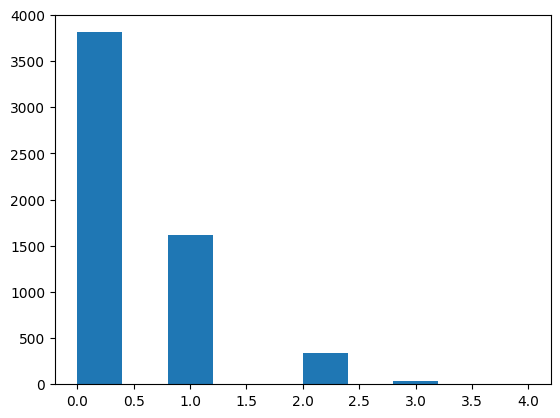

In [ ]:
plt.hist(df['gols_1_tempo_visitante'])

(array([551., 571., 592., 599., 591., 569., 563., 603., 608., 554.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

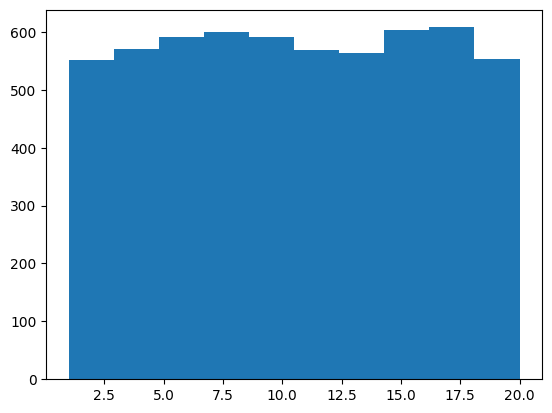

In [ ]:
plt.hist(df['colocacao_mandante'])

(array([621., 609., 584., 577., 581., 586., 603., 566., 547., 527.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

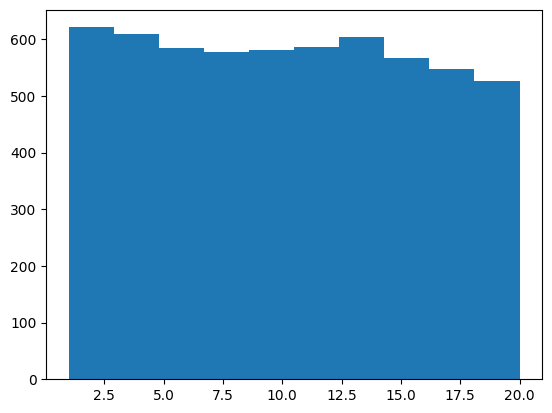

In [ ]:
plt.hist(df['colocacao_visitante'])

(array([2008., 1634.,  934.,  515.,  384.,  171.,   77.,   54.,   17.,
           7.]),
 array([    0. ,  8204.4, 16408.8, 24613.2, 32817.6, 41022. , 49226.4,
        57430.8, 65635.2, 73839.6, 82044. ]),
 <BarContainer object of 10 artists>)

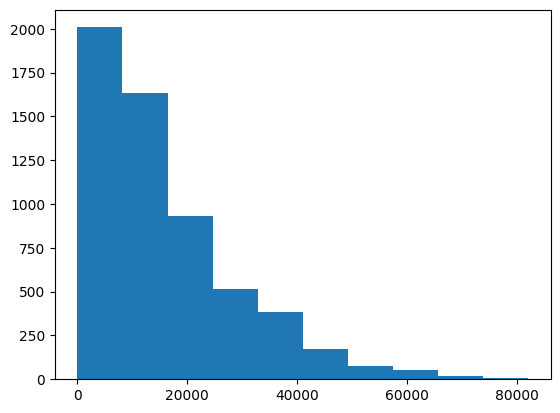

In [ ]:
plt.hist(df['publico'])

(array([2270., 1562., 1078.,  516.,  178.,   74.,   49.,   40.,   26.,
           8.]),
 array([5.6000000e+02, 1.0050504e+07, 2.0100448e+07, 3.0150392e+07,
        4.0200336e+07, 5.0250280e+07, 6.0300224e+07, 7.0350168e+07,
        8.0400112e+07, 9.0450056e+07, 1.0050000e+08]),
 <BarContainer object of 10 artists>)

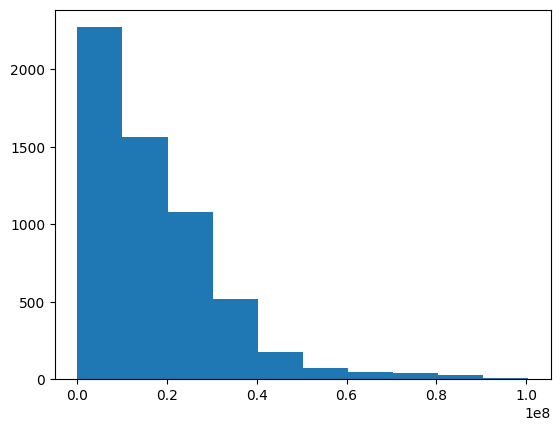

In [ ]:
plt.hist(df['valor_equipe_titular_mandante'])

(array([2158., 1577., 1100.,  578.,  176.,   95.,   51.,   38.,   16.,
          12.]),
 array([5.93000000e+02, 9.60053370e+06, 1.92004744e+07, 2.88004151e+07,
        3.84003558e+07, 4.80002965e+07, 5.76002372e+07, 6.72001779e+07,
        7.68001186e+07, 8.64000593e+07, 9.60000000e+07]),
 <BarContainer object of 10 artists>)

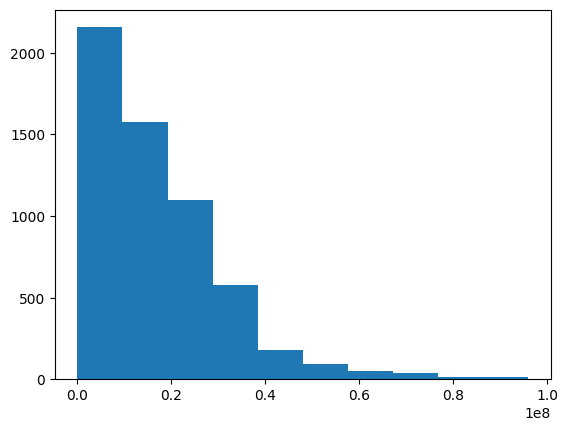

In [ ]:
plt.hist(df['valor_equipe_titular_visitante'])

###Fazer agrupamentos naturais

In [ ]:
regiao_times = {
      'Grêmio': 'Sul',
      'Internacional': 'Sul',
      'Palmeiras': 'Sudeste',
      'Santos': 'Sudeste',
      'São Paulo': 'Sudeste',
      'Corinthians': 'Sudeste',
      'Flamengo': 'Sudeste',
      'Fluminense': 'Sudeste',
      'Vasco da Gama': 'Sudeste',
      'Atlético-MG': 'Sudeste',
      'Botafogo': 'Sudeste',
      'Bahia': 'Nordeste',
      'Sport Recife': 'Nordeste',
      'Vitória': 'Nordeste',
      'Coritiba': 'Sul',
      'Goiás': 'Centro-Oeste',
      'Figueirense FC': 'Sul',
      'Cruzeiro': 'Sudeste',
      'Chapecoense': 'Sul',
      'Avaí': 'Sul',
      'Ponte Preta': 'Sudeste',
      'CSA': 'Nordeste',
      'América-MG': 'Sudeste',
      'América-RN': 'Nordeste',
      'RB Bragantino': 'Sudeste',
      'Cuiabá-MT': 'Centro-Oeste',
      'Juventude': 'Sul',
      'Paraná': 'Sul',
      'Ceará': 'Nordeste',
      'Atlético-GO': 'Centro-Oeste',
      'Athletico-PR': 'Sul',
      'Fortaleza': 'Nordeste',
      'Criciúma': 'Sul',
      'Brasiliense': 'Centro-Oeste',
      'São Caetano': 'Sudeste',
      'Santo André': 'Sudeste',
      'Guarani': 'Sudeste',
      'Náutico': 'Nordeste',
      'Santa Cruz': 'Nordeste',
      'Portuguesa': 'Sudeste',
      'Ipatinga': 'Sudeste',
      'EC Vitoria': 'Nordeste',
      'EC Bahia': 'Nordeste',
      'Barueri': 'Sudeste',
      'Joinville': 'Sul'
    }
def definir_regiao(time):
    # Dicionário para mapear os times às suas regiões

       # Variáveis para armazenar os times por região
    times_sul = []
    times_sudeste = []
    times_nordeste = []
    times_centro_oeste = []

    # Iterar sobre o dicionário e agrupar os times
    for time, regiao in regiao_times.items():
        if regiao == 'Sul':
            times_sul.append(time)
        elif regiao == 'Sudeste':
            times_sudeste.append(time)
        elif regiao == 'Nordeste':
            times_nordeste.append(time)
        elif regiao == 'Centro-Oeste':
            times_centro_oeste.append(time)

    return times_sul, times_sudeste, times_nordeste, times_centro_oeste

# Chamar a função e obter as listas de times por região
times_sul, times_sudeste, times_nordeste, times_centro_oeste = definir_regiao(df)


In [ ]:
print("Times do Sul:", times_sul)
print("Times do Sudeste:", times_sudeste)
print("Times do Nordeste:", times_nordeste)
print("Times do Centro-Oeste:", times_centro_oeste)

Times do Sul: ['Grêmio', 'Internacional', 'Coritiba', 'Figueirense FC', 'Chapecoense', 'Avaí', 'Juventude', 'Paraná', 'Athletico-PR', 'Criciúma', 'Joinville']
Times do Sudeste: ['Palmeiras', 'Santos', 'São Paulo', 'Corinthians', 'Flamengo', 'Fluminense', 'Vasco da Gama', 'Atlético-MG', 'Botafogo', 'Cruzeiro', 'Ponte Preta', 'América-MG', 'RB Bragantino', 'São Caetano', 'Santo André', 'Guarani', 'Portuguesa', 'Ipatinga', 'Barueri']
Times do Nordeste: ['Bahia', 'Sport Recife', 'Vitória', 'CSA', 'América-RN', 'Ceará', 'Fortaleza', 'Náutico', 'Santa Cruz', 'EC Vitoria', 'EC Bahia']
Times do Centro-Oeste: ['Goiás', 'Cuiabá-MT', 'Atlético-GO', 'Brasiliense']


In [ ]:
df["regiao_mandante"] = df["time_mandante"].replace(regiao_times)

In [ ]:
df["regiao_visitante"] = df["time_visitante"].replace(regiao_times)

In [ ]:
df.head(50)

,ano_campeonato,data,rodada,estadio,arbitro,publico,time_mandante,time_visitante,tecnico_mandante,tecnico_visitante,...,valor_equipe_titular_mandante,valor_equipe_titular_visitante,idade_media_titular_mandante,idade_media_titular_visitante,gols_mandante,gols_visitante,gols_1_tempo_mandante,gols_1_tempo_visitante,regiao_mandante,regiao_visitante
1722,2007,2007-05-20,2,Allianz Parque,Lourival Dias Lima Filho,19047,Palmeiras,Figueirense FC,Caio Júnior,Mário Sérgio,...,3750000.0,50000.0,26.5,23.0,2,1,2,0,Sudeste,Sul
1723,2007,2007-06-03,4,Allianz Parque,Wagner Tardelli Azevedo,13381,Palmeiras,Cruzeiro,Caio Júnior,Dorival Júnior,...,3000000.0,100000.0,24.9,27.2,1,3,1,2,Sudeste,Sudeste
1724,2007,2007-06-10,5,Allianz Parque,Evandro Rogerio Roman,21322,Palmeiras,Botafogo,Caio Júnior,Cuca,...,3750000.0,300000.0,26.9,24.5,1,1,1,0,Sudeste,Sudeste
1725,2007,2007-06-24,7,Allianz Parque,Álvaro Azeredo Quelhas,17552,Palmeiras,Athletico-PR,Caio Júnior,Antônio Lopes,...,2500000.0,1650000.0,26.5,25.1,0,2,0,1,Sudeste,Sul
1726,2007,2007-07-20,12,Allianz Parque,Salvio Fagundes Filho,18662,Palmeiras,Santos,Caio Júnior,Vanderlei Luxemburgo,...,5750000.0,7500000.0,26.4,26.4,2,2,1,2,Sudeste,Sudeste
1727,2007,2007-07-26,14,Allianz Parque,Evandro Rogerio Roman,6389,Palmeiras,Vasco da Gama,Caio Júnior,Celso Roth,...,5750000.0,800000.0,25.6,28.9,3,2,1,2,Sudeste,Sudeste
1728,2007,2007-08-02,16,Allianz Parque,Alício Pena Junior,12009,Palmeiras,Sport Recife,Caio Júnior,Geninho,...,3250000.0,1500000.0,27.4,28.8,1,2,1,2,Sudeste,Nordeste
1729,2007,2007-08-10,18,Allianz Parque,William Marcelo Souza Nery,15436,Palmeiras,Internacional,Caio Júnior,Alexandre Gallo,...,5750000.0,3050000.0,27.4,24.4,1,1,1,0,Sudeste,Sul
1730,2007,2007-08-19,20,Allianz Parque,Héber Lopes,23550,Palmeiras,Flamengo,Caio Júnior,Joel Santana,...,5000000.0,8100000.0,25.9,28.3,2,1,1,1,Sudeste,Sudeste
1731,2007,2007-09-09,25,Allianz Parque,Leonardo Gaciba da Silva,18576,Palmeiras,Goiás,Caio Júnior,Paulo Bonamigo,...,2500000.0,500000.0,25.9,28.4,2,0,1,0,Sudeste,Centro-Oeste


##Testes de Normalidade

O teste de Shapiro-Wilk é um teste estatístico que avalia a normalidade de um conjunto de dados. Ele é amplamente utilizado em análises estatísticas para verificar se uma amostra é proveniente de uma distribuição normal, que é uma suposição fundamental para muitos testes paramétricos, como o teste t e ANOVA.

In [ ]:
#teste sharpiro
for coluna in df.select_dtypes(include=['float64', 'int64']).columns:
    stat, p = stats.shapiro(df[coluna].dropna())
    print(f'{coluna}: Estatística do teste: {stat}, Valor p: {p}')

    if p > 0.05:
        print(f"{coluna}: Os dados seguem uma distribuição normal.\n")
    else:
        print(f"{coluna}: Os dados não seguem uma distribuição normal.\n")


ano_campeonato: Estatística do teste: 0.9518139783697903, Valor p: 5.063244701957407e-40
ano_campeonato: Os dados não seguem uma distribuição normal.

rodada: Estatística do teste: 0.9528898705364303, Valor p: 1.1130862051510565e-39
rodada: Os dados não seguem uma distribuição normal.

publico: Estatística do teste: 0.8953232393857209, Valor p: 1.0501843083776769e-52
publico: Os dados não seguem uma distribuição normal.

colocacao_mandante: Estatística do teste: 0.9501756668990987, Valor p: 1.5670689450093983e-40
colocacao_mandante: Os dados não seguem uma distribuição normal.

colocacao_visitante: Estatística do teste: 0.950275917582411, Valor p: 1.6821548363635327e-40
colocacao_visitante: Os dados não seguem uma distribuição normal.

valor_equipe_titular_mandante: Estatística do teste: 0.8562776017362427, Valor p: 2.0817310395130834e-58
valor_equipe_titular_mandante: Os dados não seguem uma distribuição normal.

valor_equipe_titular_visitante: Estatística do teste: 0.8628034795482422

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5801.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5801.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5801.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5801.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stat

O teste ANOVA (Análise de Variância) é usado para verificar se há diferenças significativas entre as médias de três ou mais grupos independentes.

In [ ]:
# Exibindo as informações da base
print(df.info())

# Agrupando os dados por time mandante e coletando o público em listas
groups = df.groupby('regiao_mandante')['valor_equipe_titular_mandante'].apply(list)

# Exibindo os grupos
print(groups)

# Realizando o teste ANOVA
stat, p = stats.f_oneway(*groups)

# Exibindo resultados
print(f'Estatística do teste ANOVA: {stat}, Valor p: {p}')

# Interpretação do resultado
if p > 0.05:
    print("Não há diferença significativa no valor dos times mandantes.")
else:
    print("Há diferença significativa no valor dos jogos dos times mandantes.")


<class 'pandas.core.frame.DataFrame'>
Index: 5801 entries, 1722 to 7968
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ano_campeonato                  5801 non-null   Int64         
 1   data                            5801 non-null   datetime64[ns]
 2   rodada                          5801 non-null   int64         
 3   estadio                         5801 non-null   object        
 4   arbitro                         5801 non-null   object        
 5   publico                         5801 non-null   Int64         
 6   time_mandante                   5801 non-null   object        
 7   time_visitante                  5801 non-null   object        
 8   tecnico_mandante                5801 non-null   object        
 9   tecnico_visitante               5801 non-null   object        
 10  colocacao_mandante              5801 non-null   Int64         
 11  coloca

Teste Kruskall-Walis é usado para determinar se há diferenças significativas entre as distribuições
de diferentes grupos. É uma alternativa ao teste ANOVA quando os dados não seguem uma distribuição normal ou quando as suposições da ANOVA não são atendidas.


In [ ]:

#Compara as medianas de dois ou mais grupos (dados não normais).

# Exemplo de três grupos de dados
group1 = times_sul
group2 = times_nordeste
group3 = times_centro_oeste
group4 = times_sudeste

# Teste de Kruskal-Wallis
stat, p = stats.kruskal(group1, group2, group3)
print(f'Estatística do teste: {stat}, Valor p: {p}')

if p > 0.05:
    print("Não há diferença significativa entre os grupos.")
else:
    print("Há diferença significativa entre os grupos.")


Estatística do teste: 1.3558663558663682, Valor p: 0.5076651623621471
Não há diferença significativa entre os grupos.


<Axes: >

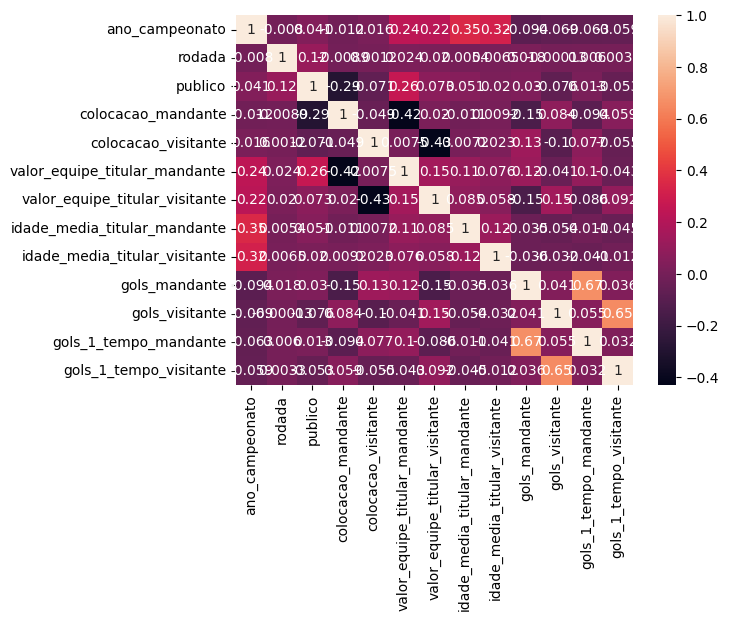

In [ ]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

##Analises

analise de de tendência ao longo do tempo

In [ ]:
# Agrupar dados por ano e calcular médias
tendencias = df.groupby('ano_campeonato').agg({
    'publico': 'mean',  # Média de público por ano
    'gols_mandante': 'mean',  # Média de gols dos mandantes por ano
    'gols_visitante': 'mean',  # Média de gols dos visitantes por ano
    'colocacao_mandante': 'mean',  # Média de colocação dos mandantes
    'colocacao_visitante': 'mean'   # Média de colocação dos visitantes
}).reset_index()
tendencias.head(20)

,ano_campeonato,publico,gols_mandante,gols_visitante,colocacao_mandante,colocacao_visitante
0,2007,18474.160142,1.701068,1.003559,10.220641,9.765125
1,2008,7918.327128,1.726064,0.992021,10.779255,10.151596
2,2009,17079.191176,1.741176,1.155882,10.964706,10.567647
3,2010,15370.21791,1.516418,1.020896,10.202985,10.170149
4,2011,15495.624595,1.660194,1.074434,10.889968,10.501618
5,2012,13759.620053,1.467018,1.005277,10.617414,10.348285
6,2013,15942.386819,1.495702,1.005731,10.335244,9.942693
7,2014,16725.418421,1.421053,0.842105,10.786842,10.213158
8,2015,17274.34626,1.470914,0.894737,10.476454,10.060942
9,2016,15451.589506,1.472222,0.895062,10.401235,10.046296


In [ ]:
# Renomear colunas para melhor visualização
tendencias.rename(columns={
    'publico': 'Média Público',
    'gols_mandante': 'Média Gols Mandante',
    'gols_visitante': 'Média Gols Visitante',
    'colocacao_mandante': 'Média Colocação Mandante',
    'colocacao_visitante': 'Média Colocação Visitante'
}, inplace=True)

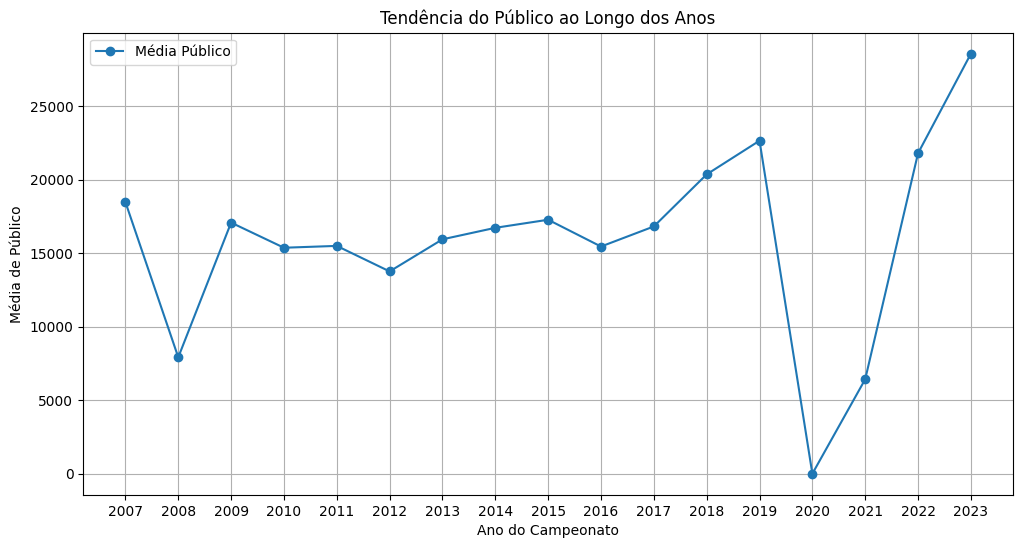

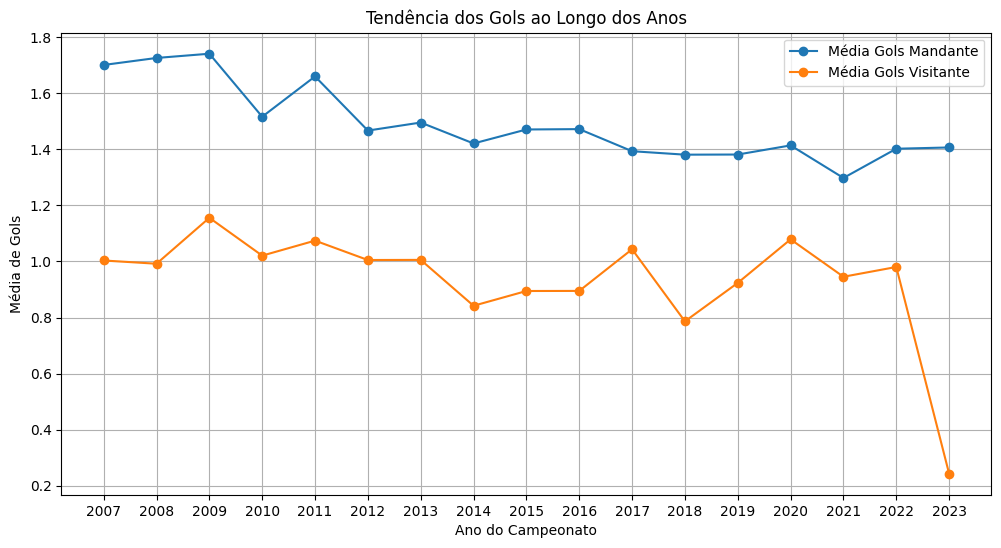

In [ ]:
# Visualizar as tendências

# Criar gráfico para o público
plt.figure(figsize=(12, 6))
plt.plot(tendencias['ano_campeonato'], tendencias['Média Público'], marker='o', label='Média Público')
plt.title('Tendência do Público ao Longo dos Anos')
plt.xlabel('Ano do Campeonato')
plt.ylabel('Média de Público')
plt.xticks(tendencias['ano_campeonato'])  # Para exibir todos os anos
plt.grid()
plt.legend()
plt.show()
# Criar gráfico para os gols
plt.figure(figsize=(12, 6))
plt.plot(tendencias['ano_campeonato'], tendencias['Média Gols Mandante'], marker='o', label='Média Gols Mandante')
plt.plot(tendencias['ano_campeonato'], tendencias['Média Gols Visitante'], marker='o', label='Média Gols Visitante')
plt.title('Tendência dos Gols ao Longo dos Anos')
plt.xlabel('Ano do Campeonato')
plt.ylabel('Média de Gols')
plt.xticks(tendencias['ano_campeonato'])  # Para exibir todos os anos
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Criar a coluna 'resultado' com base nos gols marcados e sofridos
def calcular_resultado(row):
    if row['gols_mandante'] > row['gols_visitante']:
        return 'V'  # Vitória
    elif row['gols_mandante'] < row['gols_visitante']:
        return 'D'  # Derrota
    else:
        return 'E'  # Empate

# Aplicar a função ao DataFrame
df['resultado'] = df.apply(calcular_resultado, axis=1)

# Exibir as primeiras linhas para verificar a nova coluna
print(df[['gols_mandante', 'gols_visitante', 'resultado']].head())

      gols_mandante  gols_visitante resultado
1722              2               1         V
1723              1               3         D
1724              1               1         E
1725              0               2         D
1726              2               2         E


In [ ]:
# Criar um DataFrame para calcular o desempenho dos técnicos
desempenho_tecnicos = df.groupby(['tecnico_mandante']).agg({
    'gols_mandante': 'sum',                  # Gols marcados
    'gols_visitante': 'sum',                 # Gols sofridos
    'publico': 'mean',                       # Média de público
    'resultado': lambda x: (x == 'V').sum()  # Total de vitórias
}).reset_index()

# Renomear colunas para melhor visualização
desempenho_tecnicos.rename(columns={
    'gols_mandante': 'Gols Marcados',
    'gols_visitante': 'Gols Sofridos',
    'resultado': 'Vitórias'
}, inplace=True)

# Calcular total de jogos e percentual de vitórias
desempenho_tecnicos['Total de Jogos'] = df['tecnico_mandante'].value_counts().values
desempenho_tecnicos['Percentual de Vitórias'] = (desempenho_tecnicos['Vitórias'] / desempenho_tecnicos['Total de Jogos']) * 100

# Exibir o desempenho dos técnicos
print(desempenho_tecnicos)

# Visualizar o desempenho dos técnicos
plt.figure(figsize=(12, 6))
plt.barh(desempenho_tecnicos['tecnico_mandante'], desempenho_tecnicos['Percentual de Vitórias'], color='skyblue')
plt.xlabel('Percentual de Vitórias (%)')
plt.title('Desempenho dos Técnicos - Percentual de Vitórias')
plt.grid(axis='x')
plt.show()

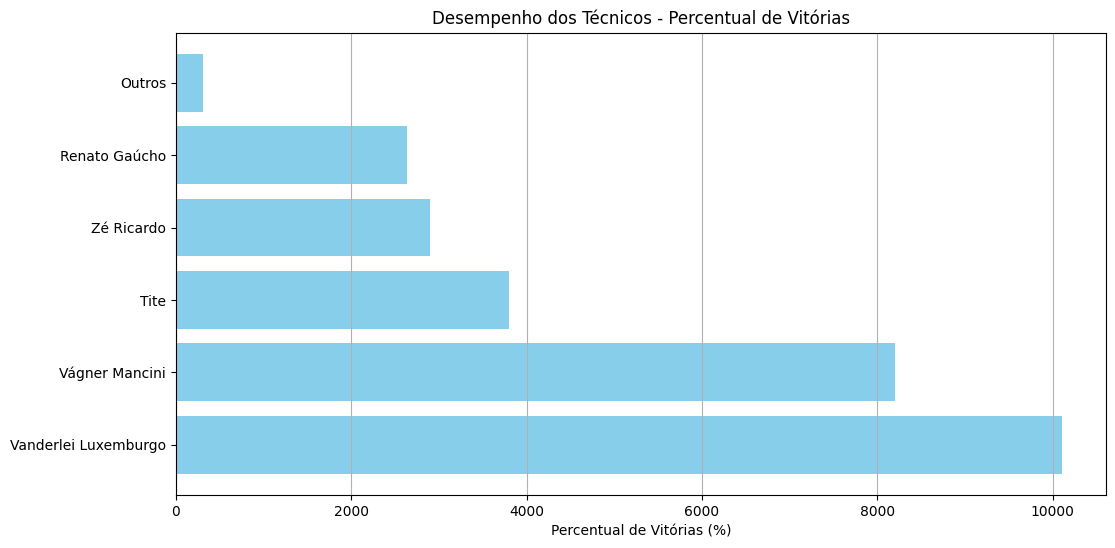

In [ ]:
# Calcular o percentual médio de vitórias dos outros técnicos
media_outros = desempenho_tecnicos['Percentual de Vitórias'][5:].mean()  # Considerando os técnicos a partir do 6º
outros_tecnicos = pd.DataFrame({'tecnico_mandante': ['Outros'], 'Percentual de Vitórias': [media_outros]})

# Selecionar os 5 técnicos com maior percentual de vitórias
top_tecnicos = desempenho_tecnicos.nlargest(5, 'Percentual de Vitórias')

# Combinar os top 5 técnicos com os demais
resultado_final = pd.concat([top_tecnicos, outros_tecnicos], ignore_index=True)

# Visualizar o desempenho dos técnicos
plt.figure(figsize=(12, 6))
plt.barh(resultado_final['tecnico_mandante'], resultado_final['Percentual de Vitórias'], color='skyblue')
plt.xlabel('Percentual de Vitórias (%)')
plt.title('Desempenho dos Técnicos - Percentual de Vitórias')
plt.grid(axis='x')
plt.show()

esse grafico mostra o desempenho dos top5 tecnicos analisados na base com maior numero de vitorias, na categoria "outros" entra o restante dos tecnicos

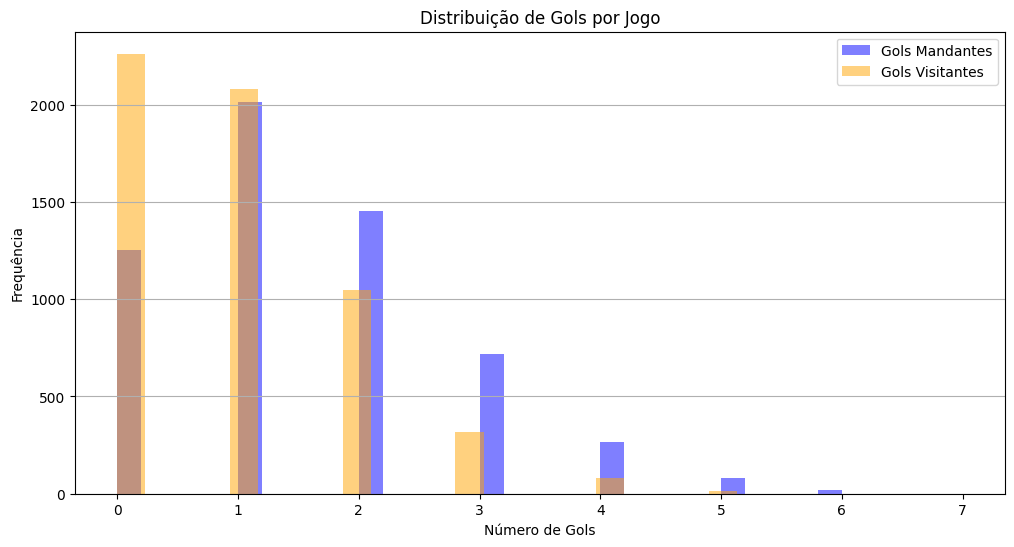

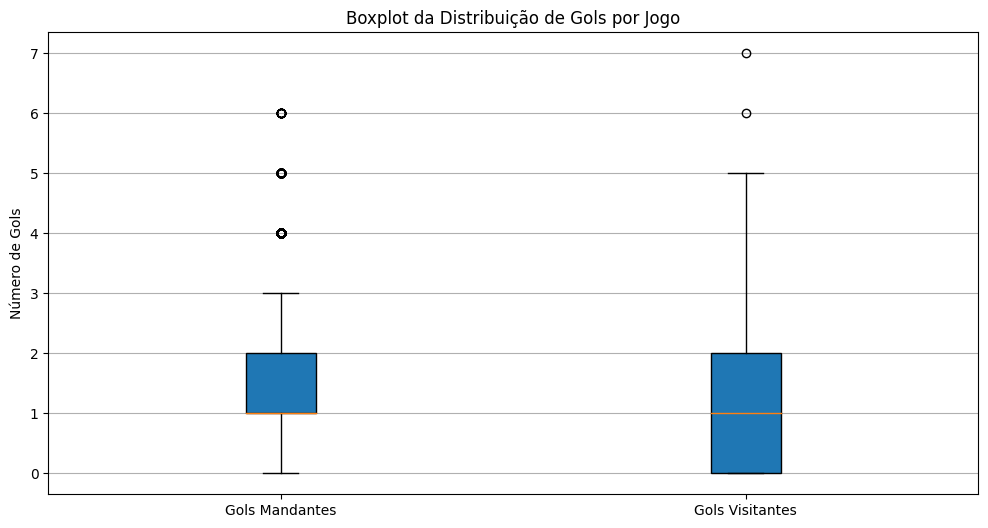

In [ ]:
# Criar um histograma para a distribuição de gols dos mandantes
plt.figure(figsize=(12, 6))
plt.hist(df['gols_mandante'].dropna(), bins=30, alpha=0.5, color='blue', label='Gols Mandantes')
plt.hist(df['gols_visitante'].dropna(), bins=30, alpha=0.5, color='orange', label='Gols Visitantes')
plt.title('Distribuição de Gols por Jogo')
plt.xlabel('Número de Gols')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y')
plt.show()

# Criar um boxplot para a distribuição de gols
plt.figure(figsize=(12, 6))
plt.boxplot([df['gols_mandante'].dropna(), df['gols_visitante'].dropna()],
            labels=['Gols Mandantes', 'Gols Visitantes'],
            patch_artist=True)
plt.title('Boxplot da Distribuição de Gols por Jogo')
plt.ylabel('Número de Gols')
plt.grid(axis='y')
plt.show()

#gols por tempo

In [ ]:
# Criar um DataFrame com os gols por tempo
gols_por_tempo = {
    'Primeiro Tempo Mandante': df['gols_1_tempo_mandante'].dropna(),
    'Primeiro Tempo Visitante': df['gols_1_tempo_visitante'].dropna(),
    'Segundo Tempo Mandante': df['gols_mandante'] - df['gols_1_tempo_mandante'],
    'Segundo Tempo Visitante': df['gols_visitante'] - df['gols_1_tempo_visitante']
}

# Agrupar os dados
gols_por_tempo_df = pd.DataFrame(gols_por_tempo)

# Resumo da quantidade de gols por tempo
print(gols_por_tempo_df.describe())

       Primeiro Tempo Mandante  Primeiro Tempo Visitante  \
count                   5801.0                    5801.0   
mean                  0.663851                  0.413894   
std                    0.80371                   0.63126   
min                        0.0                       0.0   
25%                        0.0                       0.0   
50%                        0.0                       0.0   
75%                        1.0                       1.0   
max                        5.0                       4.0   

       Segundo Tempo Mandante  Segundo Tempo Visitante  
count                  5801.0                   5801.0  
mean                 0.824685                 0.539562  
std                  0.890825                 0.741291  
min                       0.0                      0.0  
25%                       0.0                      0.0  
50%                       1.0                      0.0  
75%                       1.0                      1.0  
max

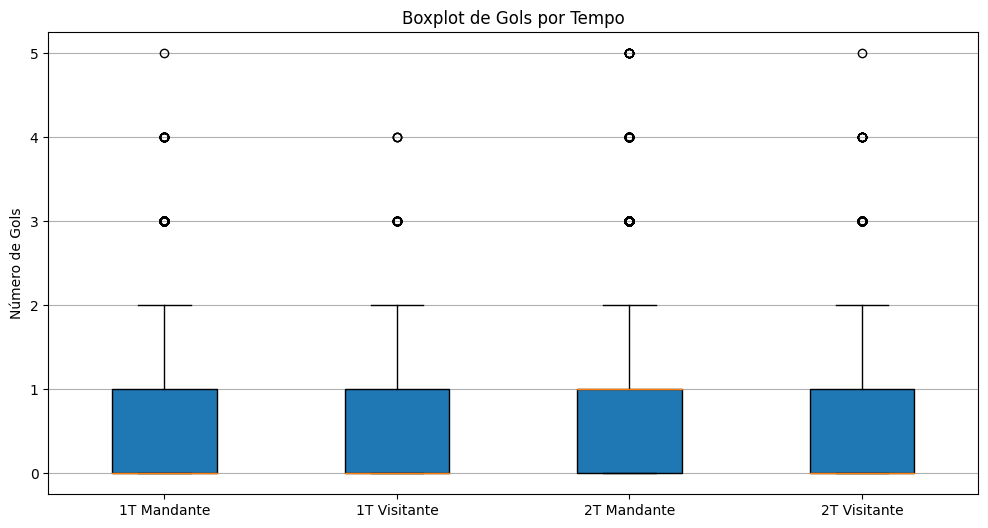

In [ ]:
# Criar um boxplot para gols por tempo
plt.figure(figsize=(12, 6))
plt.boxplot([gols_por_tempo_df['Primeiro Tempo Mandante'].dropna(),
              gols_por_tempo_df['Primeiro Tempo Visitante'].dropna(),
              gols_por_tempo_df['Segundo Tempo Mandante'].dropna(),
              gols_por_tempo_df['Segundo Tempo Visitante'].dropna()],
            labels=['1T Mandante', '1T Visitante', '2T Mandante', '2T Visitante'],
            patch_artist=True)
plt.title('Boxplot de Gols por Tempo')
plt.ylabel('Número de Gols')
plt.grid(axis='y')
plt.show()

Frequência dos Árbitros:
 arbitro
Leandro Pedro Vuaden                      257
Wilton Sampaio                            228
Héber Lopes                               206
Anderson Daronco                          200
Ricardo Marques Ribeiro                   193
                                         ... 
José Claudio Rocha Filho                    1
Maurício Aparecido de Siqueira              1
Adriano de Carvalho                         1
Frederico Honorato Moreira                  1
Paulo Belence Alves dos Prazeres Filho      1
Name: count, Length: 164, dtype: int64


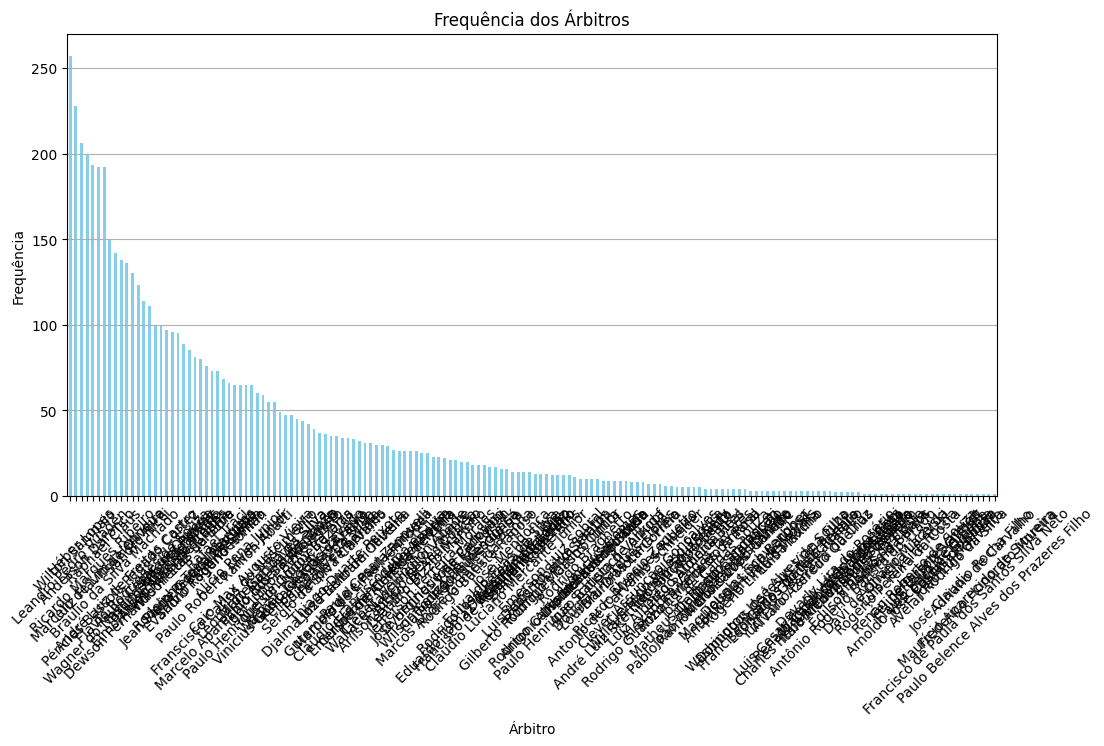


Frequência dos Estádios:
 estadio
Estádio Jornalista Mário Filho        573
Estádio Governador Magalhães Pinto    389
Estádio Urbano Caldeira               271
Estádio Cícero Pompeu de Toledo       266
Estádio Beira-Rio                     253
                                     ... 
Estádio Estadual Lourival Baptista      1
Estádio Benedito Teixeira               1
Estádio Valmir Campelo Bezerra          1
Estádio Elmo Serejo Farias              1
Estádio Municipal Parque do Sabiá       1
Name: count, Length: 80, dtype: int64


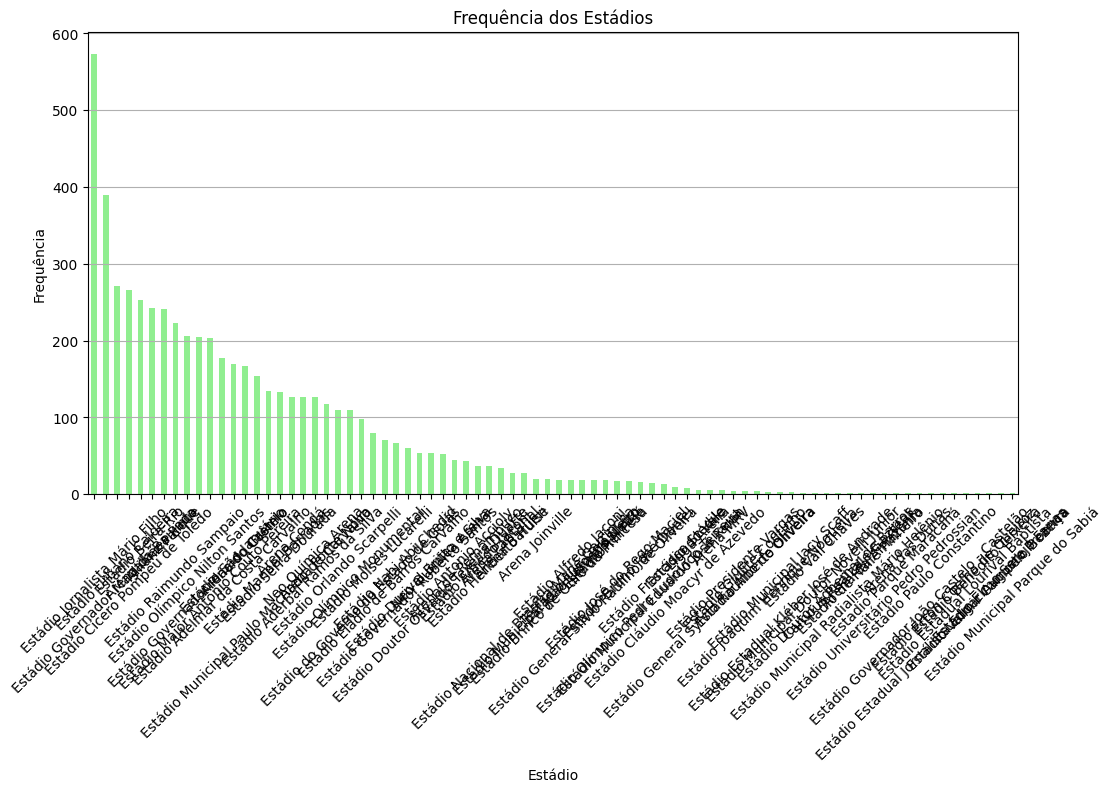


Frequência dos Times Mandantes:
 time_mandante
Fluminense        303
Atlético-MG       296
Flamengo          296
Santos            295
Corinthians       285
Grêmio            282
Palmeiras         279
Internacional     272
Athletico-PR      272
São Paulo         271
Botafogo          251
Cruzeiro          233
Coritiba          206
Sport Recife      203
Vasco da Gama     195
Goiás             178
EC Bahia          172
Vitória           145
Chapecoense       127
Avaí              126
Ceará             125
Atlético-GO       119
Figueirense FC    111
América-MG         96
Náutico            87
Fortaleza          83
Ponte Preta        81
RB Bragantino      67
Portuguesa         53
Juventude          52
Criciúma           37
Paraná             34
Barueri            33
Cuiabá-MT          27
CSA                19
Ipatinga           19
Guarani            18
Joinville          18
Santa Cruz         18
Santo André        17
Name: count, dtype: int64


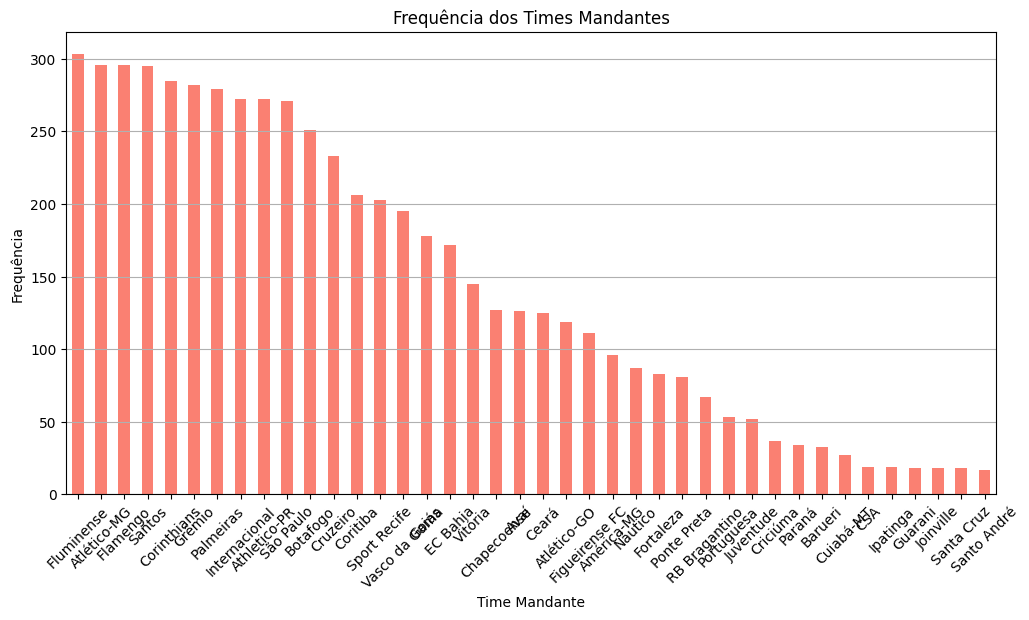

In [ ]:
# Supondo que o DataFrame já tenha sido carregado como df
# Exibir a frequência dos árbitros
frequencia_arbitros = df['arbitro'].value_counts()
print("Frequência dos Árbitros:\n", frequencia_arbitros)

# Visualizar a frequência dos árbitros
plt.figure(figsize=(12, 6))
frequencia_arbitros.plot(kind='bar', color='skyblue')
plt.title('Frequência dos Árbitros')
plt.xlabel('Árbitro')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Exibir a frequência dos estádios
frequencia_estadios = df['estadio'].value_counts()
print("\nFrequência dos Estádios:\n", frequencia_estadios)

# Visualizar a frequência dos estádios
plt.figure(figsize=(12, 6))
frequencia_estadios.plot(kind='bar', color='lightgreen')
plt.title('Frequência dos Estádios')
plt.xlabel('Estádio')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Exibir a frequência dos times mandantes
frequencia_times_mandantes = df['time_mandante'].value_counts()
print("\nFrequência dos Times Mandantes:\n", frequencia_times_mandantes)

# Visualizar a frequência dos times mandantes
plt.figure(figsize=(12, 6))
frequencia_times_mandantes.plot(kind='bar', color='salmon')
plt.title('Frequência dos Times Mandantes')
plt.xlabel('Time Mandante')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# Exibir as primeiras linhas do DataFrame para verificar as colunas
print(df.head())

# Selecionar os times para comparação
#time_a = 'Time A'  # Substitua pelo nome do time A
#time_b = 'Time B'  # Substitua pelo nome do time B

# Filtrar os confrontos diretos
confrontos = df[(df['time_mandante'].isin([times_sul, times_sudeste])) | (df['time_visitante'].isin([times_sul, times_sudeste]))]

# Exibir os confrontos diretos
print(confrontos[['data', 'time_mandante', 'gols_mandante', 'time_visitante', 'gols_visitante']])

# Calcular o desempenho dos times nos confrontos diretos
desempenho_time_a = {
    'Vitórias': len(confrontos[(confrontos['time_mandante'] == times_sul) & (confrontos['gols_mandante'] > confrontos['gols_visitante'])]) +
                   len(confrontos[(confrontos['time_visitante'] == times_sul) & (confrontos['gols_visitante'] > confrontos['gols_mandante'])]),
    'Empates': len(confrontos[(confrontos['time_mandante'] == times_sul) & (confrontos['gols_mandante'] == confrontos['gols_visitante'])]) +
                  len(confrontos[(confrontos['time_visitante'] == times_sul) & (confrontos['gols_visitante'] == confrontos['gols_mandante'])]),
    'Derrotas': len(confrontos[(confrontos['time_mandante'] == times_sul) & (confrontos['gols_mandante'] < confrontos['gols_visitante'])]) +
                    len(confrontos[(confrontos['time_visitante'] == times_sul) & (confrontos['gols_visitante'] < confrontos['gols_mandante'])]),
    'Gols Marcados': confrontos[confrontos['time_mandante'] == times_sul]['gols_mandante'].sum() + \
                     confrontos[confrontos['time_visitante'] == times_sul]['gols_visitante'].sum(),
    'Gols Sofridos': confrontos[confrontos['time_mandante'] == times_sul]['gols_visitante'].sum() + \
                     confrontos[confrontos['time_visitante'] == times_sul]['gols_mandante'].sum()
}

desempenho_time_b = {
    'Vitórias': len(confrontos[(confrontos['time_mandante'] == times_sudeste) & (confrontos['gols_mandante'] > confrontos['gols_visitante'])]) +
                   len(confrontos[(confrontos['time_visitante'] == times_sudeste) & (confrontos['gols_visitante'] > confrontos['gols_mandante'])]),
    'Empates': len(confrontos[(confrontos['time_mandante'] == times_sudeste) & (confrontos['gols_mandante'] == confrontos['gols_visitante'])]) +
                  len(confrontos[(confrontos['time_visitante'] == times_sudeste) & (confrontos['gols_visitante'] == confrontos['gols_mandante'])]),
    'Derrotas': len(confrontos[(confrontos['time_mandante'] == times_sudeste) & (confrontos['gols_mandante'] < confrontos['gols_visitante'])]) +
                    len(confrontos[(confrontos['time_visitante'] == times_sudeste) & (confrontos['gols_visitante'] < confrontos['gols_mandante'])]),
    'Gols Marcados': confrontos[confrontos['time_mandante'] == times_sudeste]['gols_mandante'].sum() + \
                     confrontos[confrontos['time_visitante'] == times_sudeste]['gols_visitante'].sum(),
    'Gols Sofridos': confrontos[confrontos['time_mandante'] == times_sudeste]['gols_visitante'].sum() + \
                     confrontos[confrontos['time_visitante'] == times_sudeste]['gols_mandante'].sum()
}

# Criar um DataFrame para o desempenho dos times
desempenho_df = pd.DataFrame({
    'Desempenho': ['Vitórias', 'Empates', 'Derrotas', 'Gols Marcados', 'Gols Sofridos'],
    times_sul: [desempenho_times_sul['Vitórias'], desempenho_times_sul['Empates'], desempenho_times_sul['Derrotas'], desempenho_times_sul['Gols Marcados'], desempenho_times_sul['Gols Sofridos']],
    times_sudeste: [desempenho_times_sudeste['Vitórias'], desempenho_times_sudeste['Empates'], desempenho_times_sudeste['Derrotas'], desempenho_times_sudeste['Gols Marcados'], desempenho_times_sudeste['Gols Sofridos']]
})

# Visualizar o desempenho dos times
desempenho_df.set_index('Desempenho').plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title(f'Comparação de Desempenho entre {times_sul} e {times_sudeste}')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Times')
plt.show()


      ano_campeonato       data  rodada         estadio  \
1722            2007 2007-05-20       2  Allianz Parque   
1723            2007 2007-06-03       4  Allianz Parque   
1724            2007 2007-06-10       5  Allianz Parque   
1725            2007 2007-06-24       7  Allianz Parque   
1726            2007 2007-07-20      12  Allianz Parque   

                       arbitro  publico time_mandante  time_visitante  \
1722  Lourival Dias Lima Filho    19047     Palmeiras  Figueirense FC   
1723   Wagner Tardelli Azevedo    13381     Palmeiras        Cruzeiro   
1724     Evandro Rogerio Roman    21322     Palmeiras        Botafogo   
1725    Álvaro Azeredo Quelhas    17552     Palmeiras    Athletico-PR   
1726     Salvio Fagundes Filho    18662     Palmeiras          Santos   

     tecnico_mandante     tecnico_visitante  ...  \
1722      Caio Júnior          Mário Sérgio  ...   
1723      Caio Júnior        Dorival Júnior  ...   
1724      Caio Júnior                  Cuca  ...  

ValueError: ('Lengths must match to compare', (0,), (11,))